### Importing libraries

In [187]:
# Database Interaction and Data Manipulation in Python
# -----------------------------------------------------------------------

# Importing necessary libraries for database connection
import psycopg2
from psycopg2 import OperationalError, errorcodes, errors

# Importing libraries for data manipulation and visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Path Configuration for Custom Module Imports
# -----------------------------------------------------------------------
import sys
sys.path.append('../')  # Adds the parent directory to the path for custom module imports

# Importing Custom Functions
from src.support import sql_query, table_creation

# Suppressing Warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

The Facua website offers a wide range of products with different sizes and subcategories, which can distort comparisons and significantly skew the conclusions of our analysis. 

For this reason, we will use a subset of data that includes only products with a volume of 1 liter.

This allows us to analyze the majority of products within the three main categories, as this packaging size is the most common in the market.

In [188]:
query_1 = """
SELECT volume
FROM product p ;
"""

df_1 = pd.DataFrame(sql_query(query_1), columns=['volume'])
# Get number of products with 1L and the others
num_prod_1l = df_1[df_1['volume'] == 1].shape[0]
num_prod_not_1l = df_1[df_1['volume'] != 1].shape[0]

Query performed successfully.
Database connection closed.


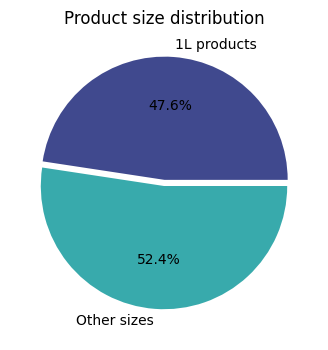

In [189]:
y = [num_prod_1l, num_prod_not_1l]
colors = sns.color_palette("mako", len(y))

plt.figure(figsize=(4, 4))
plt.pie(y, labels=['1L products', 'Other sizes'], explode=[0.05, 0], colors=colors, autopct='%1.1f%%')
plt.title("Product size distribution")
plt.show()

We see that products in the 1-liter format alone represent nearly half of the data. We will work with this subset, leaving the analysis of other formats for later stages.

We will create two views containing only information for products with a volume of 1 liter. 

* One view will include only the current products, while the other will store the entire historical data. 

* Additionally, we will display only the columns relevant to our analysis, leaving out irrelevant information such as URLs.

In [190]:
query_view_1 = """
CREATE VIEW products_v1 AS 
SELECT product_id, product, subcategory, brand 
FROM product p 
WHERE volume = 1 ;
"""

query_view_2 = """
CREATE VIEW historic_v1 AS 
SELECT p.product, c.category, p.subcategory, p.brand, s.supermarket, h."date", h.price, h.delta_price
FROM historic h 
INNER JOIN product p 
	ON h.product_id = p.product_id
INNER JOIN supermarket s
	ON s.supermarket_id = h.supermarket_id 
INNER JOIN category c 
	ON c.category_id = h.category_id
WHERE p.volume = 1 ;
"""

In [191]:
table_creation([query_view_1])
table_creation([query_view_2])

Unexpected error: relation "products_v1" already exists

Database connection closed.
Unexpected error: relation "historic_v1" already exists

Database connection closed.


### Analysis

In [192]:
query_2 = """ 
SELECT hv.category, hv.supermarket, round(AVG(hv.price), 2) AS avg_price
FROM historic_v1 hv 
GROUP BY hv.category , hv.supermarket 
ORDER BY hv.category , avg_price ;
"""

df_2 = pd.DataFrame(sql_query(query_2), columns=['category', 'supermarket', 'average_price'])

Query performed successfully.
Database connection closed.


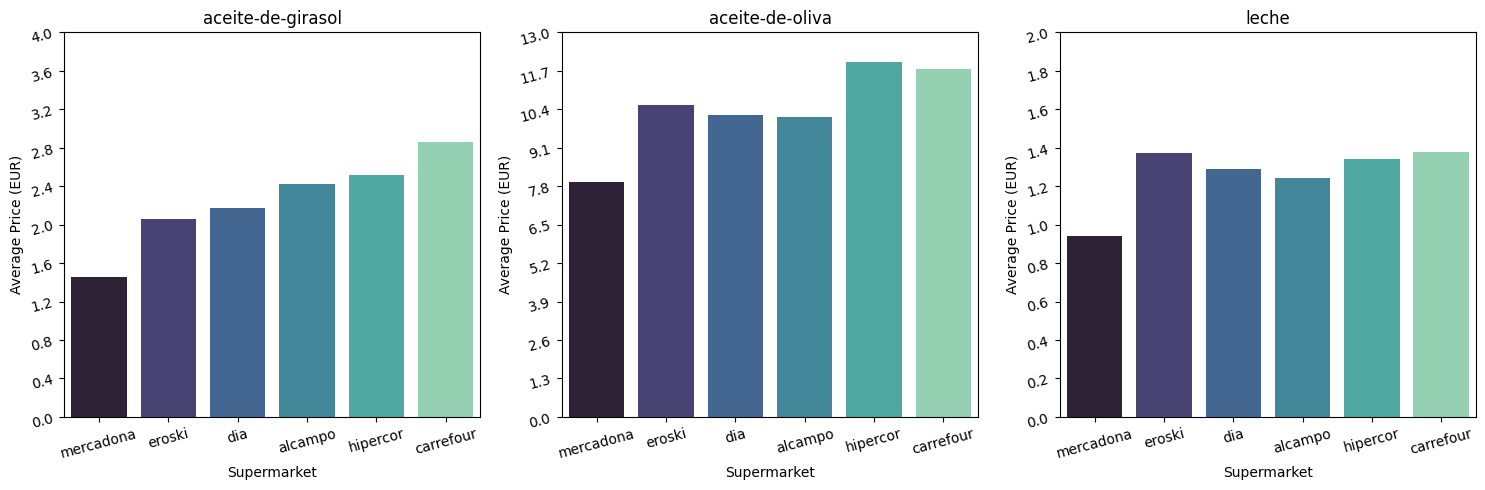

In [193]:
categories = df_2["category"].unique()
supermarkets = df_2["supermarket"].unique() 
num_categories = len(categories)

fig, axes = plt.subplots(1, num_categories, figsize=(15, 5))

for i, category in enumerate(categories):
    ax = axes[i]
    sns.barplot(
        data=df_2[df_2["category"] == category], 
        x="supermarket", 
        y="average_price", 
        ax=ax, 
        palette='mako',
        order = supermarkets
    )
    ax.set_title(category)
    ax.set_xlabel("Supermarket")
    ax.set_ylabel("Average Price (EUR)")
    ax.tick_params(rotation=15)

    min_y, max_y = ax.get_ylim()
    max_y = np.ceil(max_y)
    yticks = np.linspace(min_y, max_y, 11) 
    ax.set_yticks(yticks)

plt.tight_layout()
plt.show()

We see that a liter of olive oil is considerably more expensive than sunflower oil and milk. 

Additionally, `Mercadona` is the cheapest supermarket across all categories, while `Hipercor` and `Carrefour` are the most expensive.

Let's conduct the analysis using only the data from the most recent day:

In [194]:
query_3 = """ 
SELECT tabla.category, tabla.supermarket, tabla.avg_price
FROM (
	SELECT hv.category, hv.supermarket, round(AVG(hv.price), 2) AS avg_price, hv.date AS date
	FROM historic_v1 hv 
	GROUP BY hv.category, hv.supermarket, hv.date) AS tabla
WHERE tabla."date" in (
	SELECT max(hv.date)
	FROM historic_v1 hv) 
ORDER BY tabla.category, avg_price ;
"""

df_3 = pd.DataFrame(sql_query(query_3), columns=['category', 'supermarket', 'average_price'])

Query performed successfully.
Database connection closed.


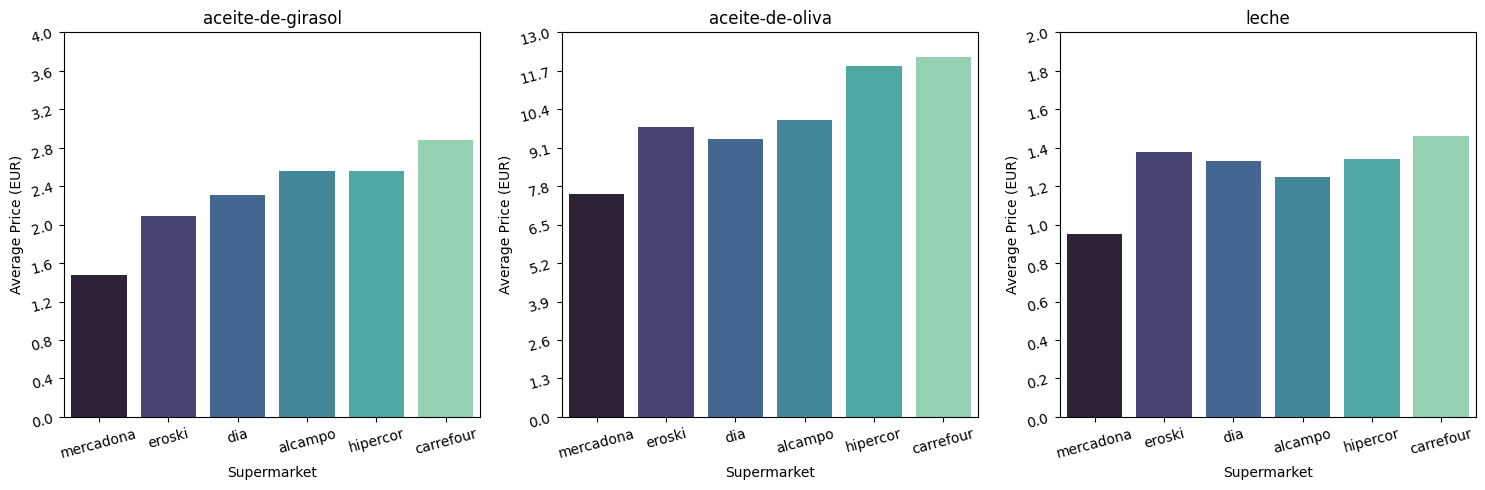

In [195]:
categories = df_3["category"].unique()
supermarkets = df_3["supermarket"].unique() 
num_categories = len(categories)

fig, axes = plt.subplots(1, num_categories, figsize=(15, 5))

for i, category in enumerate(categories):
    ax = axes[i]
    sns.barplot(
        data=df_3[df_3["category"] == category], 
        x="supermarket", 
        y="average_price", 
        ax=ax, 
        palette='mako',
        order = supermarkets
    )
    ax.set_title(category)
    ax.set_xlabel("Supermarket")
    ax.set_ylabel("Average Price (EUR)")
    ax.tick_params(rotation=15)

    min_y, max_y = ax.get_ylim()
    max_y = np.ceil(max_y)
    yticks = np.linspace(min_y, max_y, 11) 
    ax.set_yticks(yticks)

plt.tight_layout()
plt.show()

When conducting the analysis for the most recent day, we see that the results are virtually identical to the overall dataset.

We should highlight an important point: the potential difference between brands. If a supermarket carries many higher-priced brands, it can bias the analysis.

Let's conduct an analysis using the cheapest products from each supermarket.

In [143]:
query_4 = """
SELECT category, supermarket, avg_price, product
FROM (
    SELECT category, supermarket, product, brand, avg_price,
           ROW_NUMBER() OVER (PARTITION BY category, supermarket ORDER BY avg_price) AS rank
    FROM (
    	SELECT category, supermarket, product, brand, round(AVG(price), 2) AS avg_price
    	FROM historic_v1
    	GROUP BY category, supermarket, product, brand) AS avg_price_per_product
) AS ranked_products
WHERE rank = 1
ORDER BY category, supermarket;
"""

df_4 = pd.DataFrame(sql_query(query_4), columns=['category', 'supermarket', 'average_price', 'product'])

Query performed successfully.
Database connection closed.


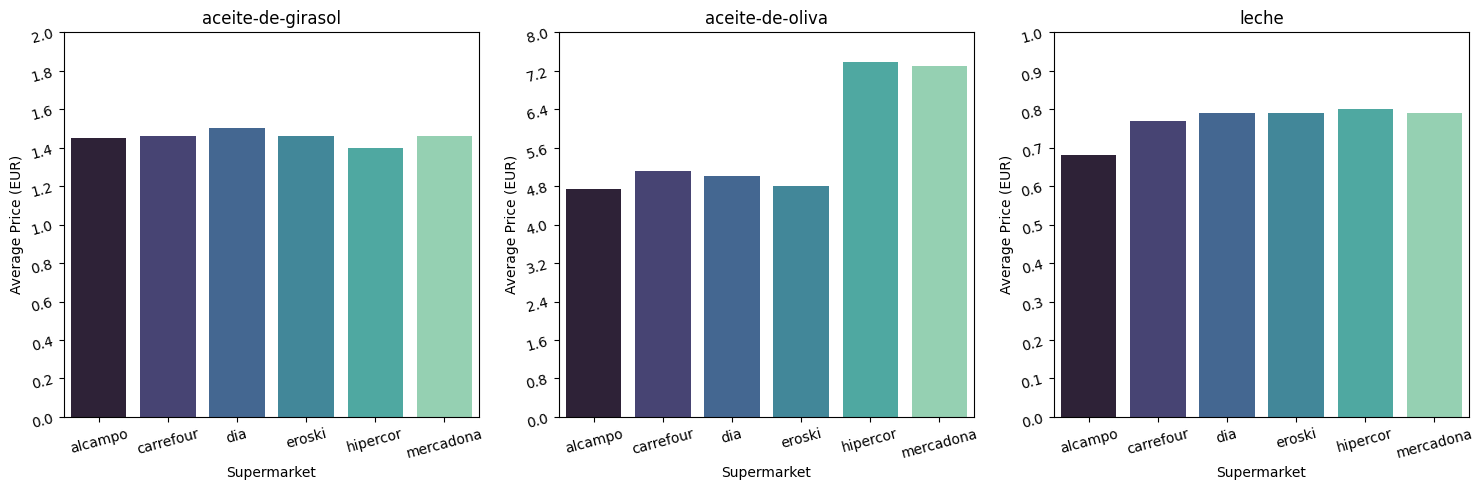

In [196]:
categories = df_4["category"].unique()
supermarkets = df_4["supermarket"].unique() 
num_categories = len(categories)

fig, axes = plt.subplots(1, num_categories, figsize=(15, 5))

for i, category in enumerate(categories):
    ax = axes[i]
    sns.barplot(
        data=df_4[df_4["category"] == category], 
        x="supermarket", 
        y="average_price", 
        ax=ax, 
        palette='mako',
        order = supermarkets
    )
    ax.set_title(category)
    ax.set_xlabel("Supermarket")
    ax.set_ylabel("Average Price (EUR)")
    ax.tick_params(rotation=15)

    min_y, max_y = ax.get_ylim()
    max_y = np.ceil(max_y)
    yticks = np.linspace(min_y, max_y, 11) 
    ax.set_yticks(yticks)

plt.tight_layout()
plt.show()

Now things change: we see that supermarkets are much more aligned in sunflower oil prices, while `Alcampo` appears to be the most affordable option for milk.

On the other hand, for olive oil, `Hipercor` and `Mercadona` seem to be significantly more expensive. Let’s take a closer look at what’s happening.

In [197]:
df_4[df_4['category'] == 'aceite-de-oliva']

,category,supermarket,average_price,product
6,aceite-de-oliva,alcampo,4.75,Producto Alcampo Aceite De Orujo De Oliva Bot...
7,aceite-de-oliva,carrefour,5.12,Aceite De Orujo De Oliva 1 L.
8,aceite-de-oliva,dia,5.01,Aceite De Orujo De Oliva La Almazara Del Oliva...
9,aceite-de-oliva,eroski,4.81,"Aceite De Orujo De Oliva Mil Olivas, Botella 1..."
10,aceite-de-oliva,hipercor,7.38,El Corte Ingles Aceite De Oliva Intenso 1º Con...
11,aceite-de-oliva,mercadona,7.29,"Aceite De Oliva 0,4º Hacendado 1 L."


We see that in all supermarkets, the cheapest option is olive pomace oil (aceite de orujo de oliva), while in Mercadona and Hipercor, it’s regular olive oil. Olive pomace oil is not pure olive oil; it’s a blend that includes moist olive pomace, which lowers its value. Therefore, we can’t consider this result as conclusive for our analysis.

We could, for example, select the cheapest extra virgin olive oil (`AOVE`) from each supermarket to conduct a fairer comparison.

In [198]:
query_5 = """SELECT supermarket, avg_price, product
FROM (
    SELECT supermarket, product, brand, avg_price,
           ROW_NUMBER() OVER (PARTITION BY supermarket ORDER BY avg_price) AS rank
    FROM (
    	SELECT supermarket, product, brand, round(AVG(price), 2) AS avg_price
    	FROM historic_v1
    	WHERE subcategory = 'virgen extra'
    	GROUP BY category, supermarket, product, brand) AS avg_price_per_product
) AS ranked_products
WHERE rank = 1
ORDER BY supermarket ;"""

df_5 = pd.DataFrame(sql_query(query_5), columns=['supermarket', 'average_price', 'product'])

Query performed successfully.
Database connection closed.


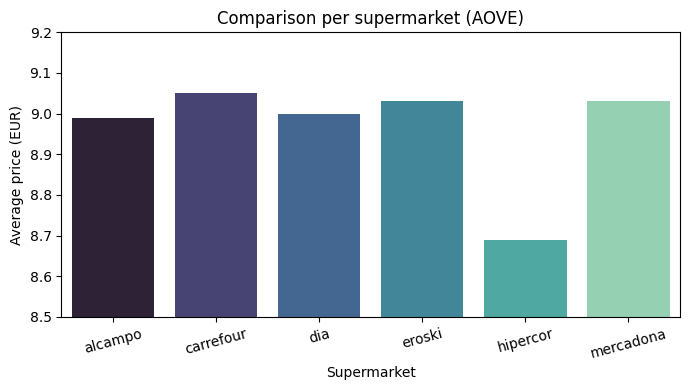

In [199]:
plt.figure(figsize=(7, 4))
sns.barplot(
    x = "supermarket",
    y = "average_price",
    data = df_5,
    palette='mako'
)

plt.xticks(rotation=15)
plt.title("Comparison per supermarket (AOVE)")
plt.xlabel("Supermarket")
plt.ylabel("Average price (EUR)")
plt.ylim((8.5, 9.2))
plt.tight_layout()
plt.show()

Focusing on extra virgin olive oil, we see that prices are now quite similar across supermarkets, although Hipercor has the lowest average, with a difference of around 30 cents compared to the others.

In [200]:
query_6 = """ 
SELECT date, category, supermarket, AVG(price) AS avg_price
FROM historic_v1
GROUP BY date, category, supermarket
ORDER BY category, supermarket, date;
"""

df_6 = pd.DataFrame(sql_query(query_6), columns=['date', 'category', 'supermarket', 'average_price'])

Query performed successfully.
Database connection closed.


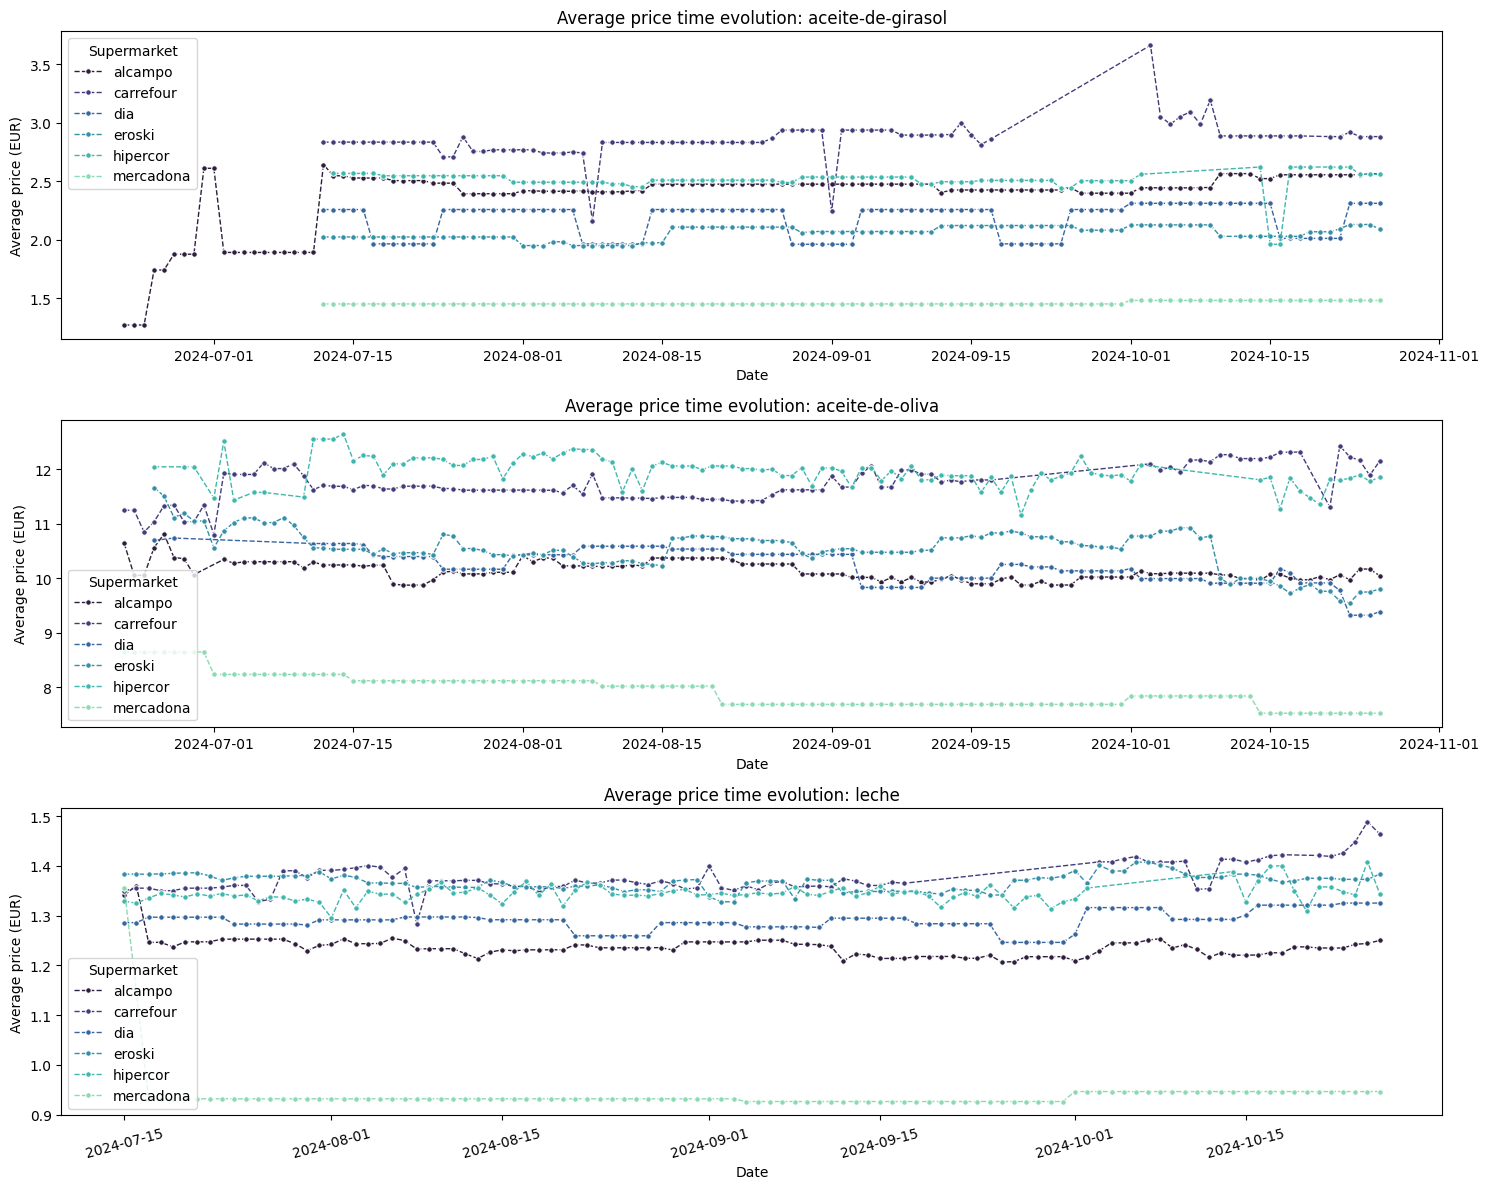

In [201]:
categories = df_6['category'].unique()

num_categories = len(categories)
fig, axes = plt.subplots(nrows=num_categories, figsize=(15, 12))

for i, category in enumerate(categories):
    ax = axes[i]
    df_category = df_6[df_6['category'] == category]
    sns.lineplot(data=df_category, 
                 x="date", 
                 y="average_price", 
                 hue="supermarket", 
                 ax=ax, 
                 marker = "o",
                 markersize = 4,
                 linewidth = 1, 
                 palette="mako", 
                 linestyle = "dashed")
    ax.set_title(f"Average price time evolution: {category}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Average price (EUR)")
    ax.legend(title="Supermarket")

plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


The overall price trend is fairly steady, without significant spikes. Given that the time frame is only 4 months, a longer period of monitoring may be necessary to identify clear trends.

* Sunflower oil (aceite de girasol): `Alcampo` initially had the lowest prices among supermarkets, but a price increase brought it up to the level of its competitors. `Carrefour` experienced a notable increase in early October, though missing data from previous days makes it difficult to determine if there was a gradual rise.

* Olive oil (aceite de oliva): The trend for olive oil is similar to that of sunflower oil, with generally stable prices.

* Milk (leche): Milk prices also follow a stable pattern across all supermarkets, with no major changes.

It is worth noting that `Mercadona` remains the supermarket with the lowest and most stable prices, which is due to only having one brand in the database (Hacendado), as we will confirm below.

In [168]:
query_7 = """
SELECT category, supermarket, COUNT(DISTINCT brand) AS num_brands
FROM historic_v1
GROUP BY category, supermarket
ORDER BY category, supermarket, num_brands;
"""

df_7 = pd.DataFrame(sql_query(query_7), columns=['category', 'supermarket', 'count'])

Query performed successfully.
Database connection closed.


In [174]:
df_7

,category,supermarket,count
0,aceite-de-girasol,alcampo,11
1,aceite-de-girasol,carrefour,6
2,aceite-de-girasol,dia,2
3,aceite-de-girasol,eroski,7
4,aceite-de-girasol,hipercor,8
5,aceite-de-girasol,mercadona,1
6,aceite-de-oliva,alcampo,23
7,aceite-de-oliva,carrefour,16
8,aceite-de-oliva,dia,9
9,aceite-de-oliva,eroski,18


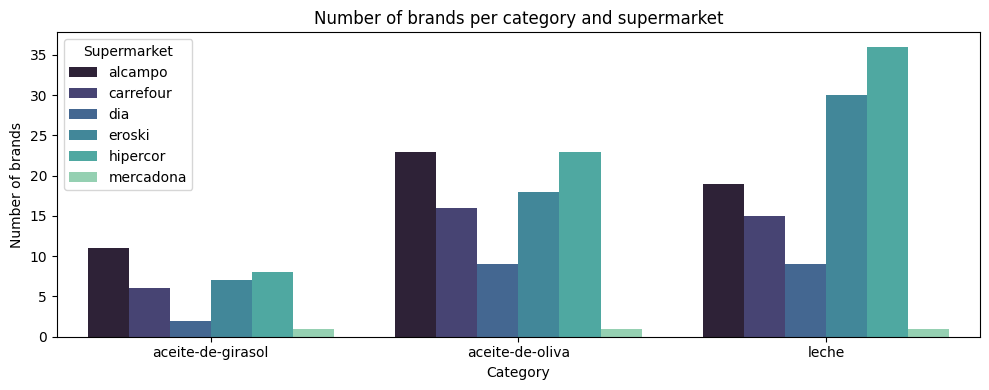

In [202]:
plt.figure(figsize=(10, 4))
sns.barplot(data=df_7, 
            x="category", 
            y="count", 
            hue="supermarket", 
            dodge=True, 
            palette='mako')
plt.title("Number of brands per category and supermarket")
plt.xlabel("Category")
plt.ylabel("Number of brands")
plt.legend(title="Supermarket")
plt.tight_layout()
plt.show()

We can confirm that `Mercadona` indeed carries only one brand (Hacendado) across all categories, while other supermarkets offer more options.

As noted earlier, this creates biases when comparing supermarkets, so it may be more effective to compare individual brands instead."

In [181]:
query_8 = """
SELECT category, supermarket, product, AVG(price) AS avg_price
FROM historic_v1
GROUP BY category, supermarket, product
ORDER BY category, supermarket;
"""

df_8 = pd.DataFrame(sql_query(query_8), columns=['category', 'supermarket', 'product', 'avg_price'])

Query performed successfully.
Database connection closed.


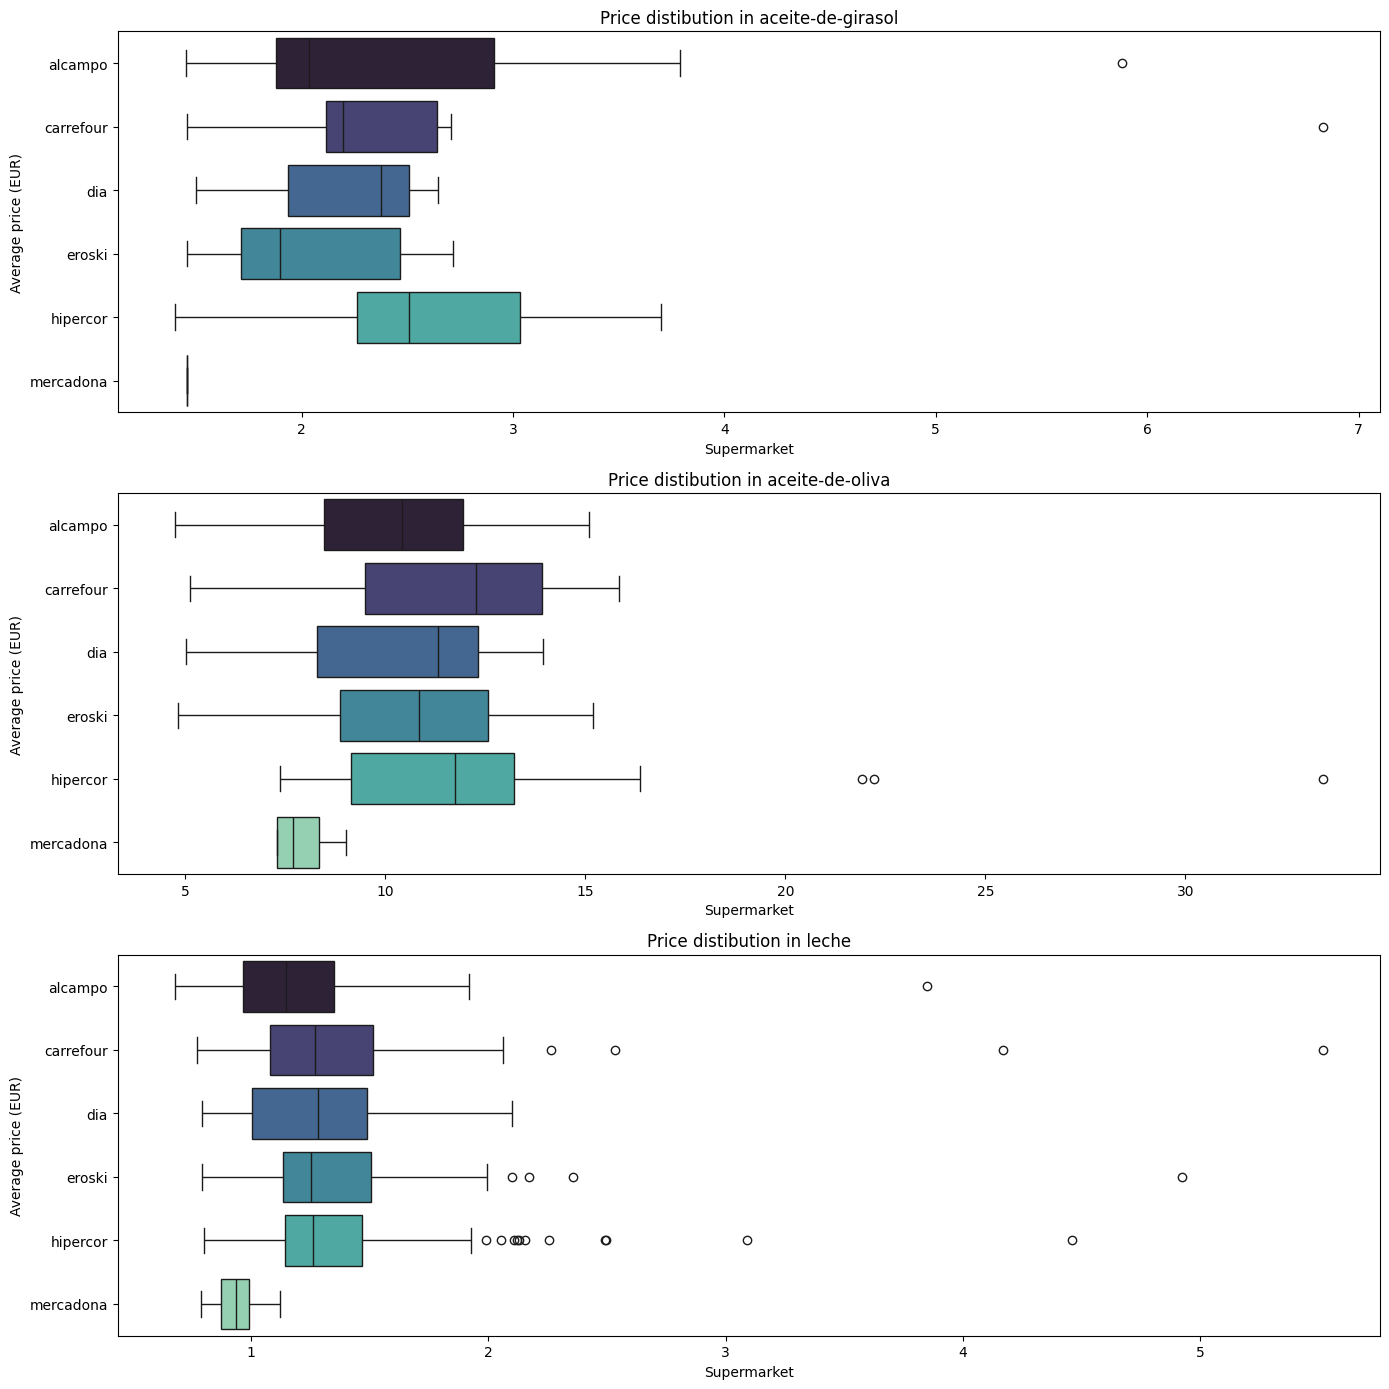

In [203]:
categories = df_8['category'].unique()
num_categories = len(categories)
fig, axes = plt.subplots(nrows=num_categories, figsize=(14, 14))

# Crear un gráfico para cada categoría
for i, category in enumerate(categories):
    ax = axes[i]  # Seleccionar el eje correspondiente
    df_category = df_8[df_8['category'] == category]
    sns.boxplot(data=df_category, 
                y="supermarket", 
                x="avg_price", 
                ax=ax, 
                palette='mako')
    ax.set_title(f"Price distibution in {category}")
    ax.set_xlabel("Supermarket")
    ax.set_ylabel("Average price (EUR)")

plt.tight_layout()
plt.show()

Once again, we see that `Mercadona` has a much narrower price range due to offering only one brand, while other supermarkets show greater variability. Notable outliers appear, particularly in the milk category, likely due to the variety of milk types available, which can account for this wider price range.